## Лабораторная 4: восстановление плотности распределения

Данными в этом задании являются измерения некоторых проверочных параметров на конвейерах  сборки оборудования Bosh (см. [конкурс](https://www.kaggle.com/c/bosch-production-line-performance) «Bosch Production Line Performance» на Kaggle). 

Все исходные данные Bosh не помещаются в оперативную память компьютера, поэтому в файле `data.csv` — лишь некоторые признаки. Прочтите данные из файла `data.csv`. Целевым признаком здесь является `Response` — наличие брака в оборудовании. 

In [11]:
import pandas as pd

In [12]:
data=pd.read_csv('data.csv',delimiter=',')

## 1 
Постройте на одном графике два приближения к плотности распределения признака `L1_S24_F1846` для `Response = 0` и для `Response = 1`, используя одно из следующих ядер (номер ядра выберите по формуле: `(n mod 6) + 1`, где `n` — ваш номер в списке группы):

    1.	кусочно-постоянное (прямоугольное) -  tophat
    2.	гауссовское -  gaussian
    3.	линейное (треугольник) -  linear
    4.	косинусоидальное -  cosine
    5.	квадратичное (Епанечникова) -  epanechnikov
    6.	экспоненциальное -  exponential


In [13]:
from sklearn.neighbors._kde import KernelDensity
#from sklearn.neighbors.kde import KernelDensity !данная команда на новых версиях не работает!
import numpy as np

import matplotlib.pyplot as plt

*Help:*

    i0 = data['Response'] == 0
    kde0 = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(data.loc[i0, 'L1_S24_F1846'].values.reshape(-1, 1))
    X_plot = np.linspace(-1, 1, 1000).reshape(-1, 1)
    Dens0 = np.exp(kde0.score_samples(X_plot))  # score_samples возвращает логарифм плотности

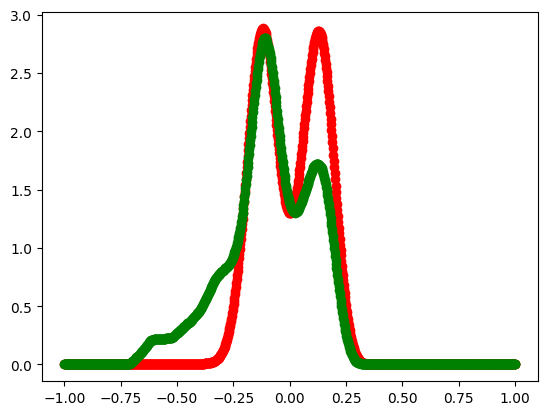

In [14]:
# 2 mod 6+1=3 
i0 = data['Response'] == 0
kde0 = KernelDensity(kernel='linear', bandwidth=0.1).fit(data.loc[i0, 'L1_S24_F1846'].values.reshape(-1, 1))
X_plot = np.linspace(-1, 1, 1000).reshape(-1, 1)
Dens0 = np.exp(kde0.score_samples(X_plot))  # score_samples возвращает логарифм плотности

i1 = data['Response'] == 1
kde1 = KernelDensity(kernel='linear', bandwidth=0.1).fit(data.loc[i1, 'L1_S24_F1846'].values.reshape(-1, 1))
Dens1 = np.exp(kde1.score_samples(X_plot))  # score_samples возвращает логарифм плотности

plt.scatter(X_plot,Dens0,color='red')
plt.scatter(X_plot,Dens1,color='green')
plt.show()



Ответьте в комментариях на вопрос: является ли выборка хорошо разделимой по признаку  `L1_S24_F1846`?

In [15]:
#В некотороыхы местах сливается

## 2

Разбейте выборку `data` на две равные части: тренировочную `dataTrain` и проверочную `dataTest`. 

In [16]:
dataTrain = data.loc[0:data.shape[0] / 2, ].reset_index(drop=True)
dataTest = data.loc[data.shape[0] / 2:data.shape[0], ].reset_index(drop=True)

Пользуясь кросс-валидацией, подберите **для каждого класса `Response` (`r=0` и `r=1`)** значение ширины ядра `bandwidth`, при котором логарифм правдоподобия максимален на проверочной выборке.

*Help:*

    r = 0
    kde0 = KernelDensity(kernel='gaussian', bandwidth=0.05)
    kde0.fit(dataTrain.loc[dataTrain['Response']==r, 'L1_S24_F1846'].values.reshape(-1, 1))
    logProbability0 = kde0.score_samples(dataTest.loc[dataTest['Response']==r, 'L1_S24_F1846'].values.reshape(-1, 1))
    logProbability0[np.isinf(logProbability0)] = -100 # заменяем -бесконечность
    logLikehood0 = logProbability0.sum()
    print(logLikehood0)

In [17]:
r = 0
kde0 = KernelDensity(kernel='linear', bandwidth=0.05)
kde0.fit(dataTrain.loc[dataTrain['Response']==r, 'L1_S24_F1846'].values.reshape(-1, 1))
logProbability0 = kde0.score_samples(dataTest.loc[dataTest['Response']==r, 'L1_S24_F1846'].values.reshape(-1, 1))
logProbability0[np.isinf(logProbability0)] = -100 # заменяем -бесконечность
logLikehood0 = logProbability0.sum()
print(logLikehood0)

r = 1
kde1 = KernelDensity(kernel='linear', bandwidth=0.05)
kde1.fit(dataTrain.loc[dataTrain['Response']==r, 'L1_S24_F1846'].values.reshape(-1, 1))
logProbability1 = kde1.score_samples(dataTest.loc[dataTest['Response']==r, 'L1_S24_F1846'].values.reshape(-1, 1))
logProbability1[np.isinf(logProbability1)] = -100 # заменяем -бесконечность
logLikehood1 = logProbability1.sum()
print(logLikehood1)



21996.692547839983
114.80410633230645


### 3

Для найденных наилучших `bandwidth` вычислите `p(x|0)` и `p(x|1)` для тестовой выборки. 

In [18]:
predictionProbXafter0 = np.exp(kde0.score_samples(dataTest['L1_S24_F1846'].values.reshape(-1, 1)))
predictionProbXafter1 = np.exp(kde1.score_samples(dataTest['L1_S24_F1846'].values.reshape(-1, 1)))
prob1 = dataTest['Response'].mean()
prob0 = 1 - prob1
probX = predictionProbXafter0 * prob0 + predictionProbXafter1 * prob1
predictionProb0afterX = (predictionProbXafter0 * prob0) / probX
predictionProb1afterX = (predictionProbXafter1 * prob1) / probX

C:\Users\Кирилл\AppData\Local\Temp\ipykernel_9832\2163624431.py:6: RuntimeWarning: invalid value encountered in divide
  predictionProb0afterX = (predictionProbXafter0 * prob0) / probX
C:\Users\Кирилл\AppData\Local\Temp\ipykernel_9832\2163624431.py:7: RuntimeWarning: invalid value encountered in divide
  predictionProb1afterX = (predictionProbXafter1 * prob1) / probX


По формуле Байеса найдите затем `p(0|x)` и `p(1|x)`. Отсортируйте все объекты тестовой выборки по возрастанию предсказанной вероятности `p(1|x)`, выведите на экран вероятности для последних 10 объектов и рассчитайте количество бракованных деталей среди последних 100 объектов в отсортированном ряду.

*Help:*
    
    ind = np.argsort(predictionProb1afterX) - сортировка, возвращающая индексы элементов
    print(predictionProb1afterX[ind[-10:]]) - вывод последних 10 элементов
    print(sum(dataTest.loc[ind[-100:],'Response'])) - количество бракованных среди 100 с максимальной вероятностью брака

In [19]:
ind = np.argsort(predictionProb1afterX) # сортировка, возвращающая индексы элементов
print(predictionProb1afterX[ind[-10:]]) # вывод последних 10 элементов
print(sum(dataTest.loc[ind[-100:],'Response'])) # количество бракованных среди 100 с максимальной вероятностью брака

[0.61155556 0.61155556 0.61206999 0.61206999 0.61755211 0.63044663
 0.65783869 0.65783869        nan        nan]
29
